In [1]:
import os
import time
import requests
import sys

In [2]:
## Using web scraping extracting climate data for Dhaka
def retrieve_html():
    for year in range(2014,2021):
        for month in range(1,13):
            if(month<10):
                url='http://en.tutiempo.net/climate/0{}-{}/ws-419230.html'.format(month
                                                                          ,year)
            else:
                url='http://en.tutiempo.net/climate/{}-{}/ws-419230.html'.format(month
                                                                          ,year)
            texts=requests.get(url)
            text_utf=texts.text.encode('utf=8')
            
            if not os.path.exists("Data/Html_Data/{}".format(year)):
                os.makedirs("Data/Html_Data/{}".format(year))
            with open("Data/Html_Data/{}/{}.html".format(year,month),"wb") as output:
                output.write(text_utf)
            
        sys.stdout.flush()

In [3]:
## Extracting HTML data
start_time=time.time()
retrieve_html()
stop_time=time.time()
print("Time taken {}".format(stop_time-start_time))

Time taken 75.32517910003662


In [4]:
## uploading PM2.5 data which will be used as dependent variable
import pandas as pd
from bs4 import BeautifulSoup
import csv
from google.colab import files
uploaded = files.upload()

Saving dhaka-us consulate-air-quality.csv to dhaka-us consulate-air-quality.csv


In [5]:
## will be used to combine varoius years data
def data_combine(year, cs):
  for a in pd.read_csv('Data/Real-Data/real_' + str(year) + '.csv', chunksize=cs):
    df = pd.DataFrame(data=a)
    mylist = df.values.tolist()
  return mylist

In [6]:
## spitting dependent variable (target) data into the years that will be analyzed 
import pandas as pd
import matplotlib.pyplot as plt

pm2016 = []
pm2017 = []
pm2018 = []

for rows in pd.read_csv('dhaka-us consulate-air-quality.csv',chunksize=100):
  df=pd.DataFrame(data=rows)
  for index,row in df.iterrows():
    if("2016" in row["date"]):
      pm2016.append(row[1])
    elif("2017" in row["date"]):
      pm2017.append(row[1])
    elif("2018" in row["date"]):
      pm2018.append(row[1])

def getPM_2016():
  return pm2016

def getPM_2017():
  return pm2017

def getPM_2018():
  return pm2018

In [7]:
## extracting data from HTML pages that were saved
import numpy as np
def met_data(month, year):
  file_html = open('Data/Html_Data/{}/{}.html'.format(year,month), 'rb')
  plain_text = file_html.read()

  tempD = []
  finalD = []

  soup = BeautifulSoup(plain_text, "lxml")
  for table in soup.findAll('table', {'class': 'medias mensuales numspan'}):
    for tbody in table:
      for tr in tbody:
        a = tr.get_text()
        tempD.append(a)

  # print("tempD: ",tempD)
  rows = len(tempD) / 15

  for times in range(round(rows)):
    newtempD = []
    for i in range(15):
      newtempD.append(tempD[0])
      # print(tempD[0])
      tempD.pop(0)
    finalD.append(newtempD)
  
  
  length = len(finalD)
  # print("Final ID: ",finalD)

  finalD.pop(length - 1)
  finalD.pop(0)

  for a in range(len(finalD)):
    finalD[a].pop(6)
    finalD[a].pop(13)
    finalD[a].pop(12)
    finalD[a].pop(11)
    finalD[a].pop(10)
    finalD[a].pop(9)
    finalD[a].pop(0)
  # print("Final ID: ",finalD)
  return finalD

In [8]:
## merge dependent and independent variale data and saved them as CSV file
if not os.path.exists("Data/Real-Data"):
  os.makedirs("Data/Real-Data")

for year in range(2016, 2019):
  final_data = []
  with open('Data/Real-Data/real_' + str(year) + '.csv', 'w') as csvfile:
    wr = csv.writer(csvfile, dialect='excel')
    wr.writerow(['T', 'TM', 'Tm', 'SLP', 'H', 'VV', 'V', 'VM','PM2.5'])
  for month in range(1, 13):
    
    temp = met_data(month, year)
    
    final_data = final_data + temp

  ## reading dependent variable data
  pm = getattr(sys.modules[__name__], 'getPM_{}'.format(year))()
 
  avgPM = sum(pm)/len(pm)
 
  for i in range(len(final_data)):
    if(i>len(pm)-1):
     final_data[i].insert(8, avgPM)
    else: 
     final_data[i].insert(8, pm[i])


  with open('Data/Real-Data/real_' + str(year) + '.csv', 'a') as csvfile:
     wr = csv.writer(csvfile, dialect='excel')
     for row in final_data:
       flag = 0
       for elem in row:
          if elem == "" or elem == "-":
            flag = 1
       if flag != 1:
         wr.writerow(row)
#combining data
data_2016 = data_combine(2016, 100)
data_2017 = data_combine(2017, 600)
data_2018 = data_combine(2018, 600)

total=data_2016+data_2017+data_2018

with open('Data/Real-Data/Real_Combine.csv', 'w') as csvfile:
  wr = csv.writer(csvfile, dialect='excel')
  wr.writerow(['T', 'TM', 'Tm', 'SLP', 'H', 'VV', 'V', 'VM','PM2.5'])
  wr.writerows(total)

df=pd.read_csv('Data/Real-Data/Real_Combine.csv')

In [9]:
import seaborn as sns
df=pd.read_csv('Data/Real-Data/Real_Combine.csv')

In [10]:
df.head()

,T,TM,Tm,SLP,H,VV,V,VM,PM2.5
0,29.3,34.1,26.5,1004.7,83.0,4.5,1.9,3.5,73.0
1,29.0,34.0,25.8,1007.0,79.0,4.5,0.6,3.5,93.0
2,28.9,32.3,27.2,1008.5,84.0,5.0,0.7,3.5,176.0
3,28.1,33.0,26.4,1004.8,84.0,4.5,0.7,3.5,198.0
4,28.8,33.5,26.6,1004.3,79.0,4.7,0.6,3.5,205.0


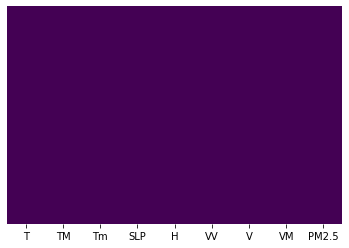

In [11]:
## Checking if there is any null value
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [12]:
## droping null value
df=df.dropna()

In [13]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]

In [14]:
X.isnull()

,T,TM,Tm,SLP,H,VV,V,VM
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
290,False,False,False,False,False,False,False,False
291,False,False,False,False,False,False,False,False
292,False,False,False,False,False,False,False,False
293,False,False,False,False,False,False,False,False


In [15]:
y.isnull()

0      False
1      False
2      False
3      False
4      False
       ...  
290    False
291    False
292    False
293    False
294    False
Name: PM2.5, Length: 295, dtype: bool

In [16]:
## observing correlationg
df.corr()

,T,TM,Tm,SLP,H,VV,V,VM,PM2.5
T,1.000000,0.901099,0.897262,-0.719118,0.242698,0.783086,0.213611,0.120505,-0.070534
TM,0.901099,1.000000,0.727268,-0.553135,0.019902,0.747051,0.128073,0.127030,-0.146478
Tm,0.897262,0.727268,1.000000,-0.778452,0.514333,0.660190,0.218347,0.120399,0.038461
SLP,-0.719118,-0.553135,-0.778452,1.000000,-0.543170,-0.490176,-0.306727,-0.197025,0.017853
H,0.242698,0.019902,0.514333,-0.543170,1.000000,0.067768,0.224532,0.158039,0.074588
VV,0.783086,0.747051,0.660190,-0.490176,0.067768,1.000000,0.209864,0.089865,-0.178726
V,0.213611,0.128073,0.218347,-0.306727,0.224532,0.209864,1.000000,0.673690,-0.104642
VM,0.120505,0.127030,0.120399,-0.197025,0.158039,0.089865,0.673690,1.000000,-0.073694
PM2.5,-0.070534,-0.146478,0.038461,0.017853,0.074588,-0.178726,-0.104642,-0.073694,1.000000


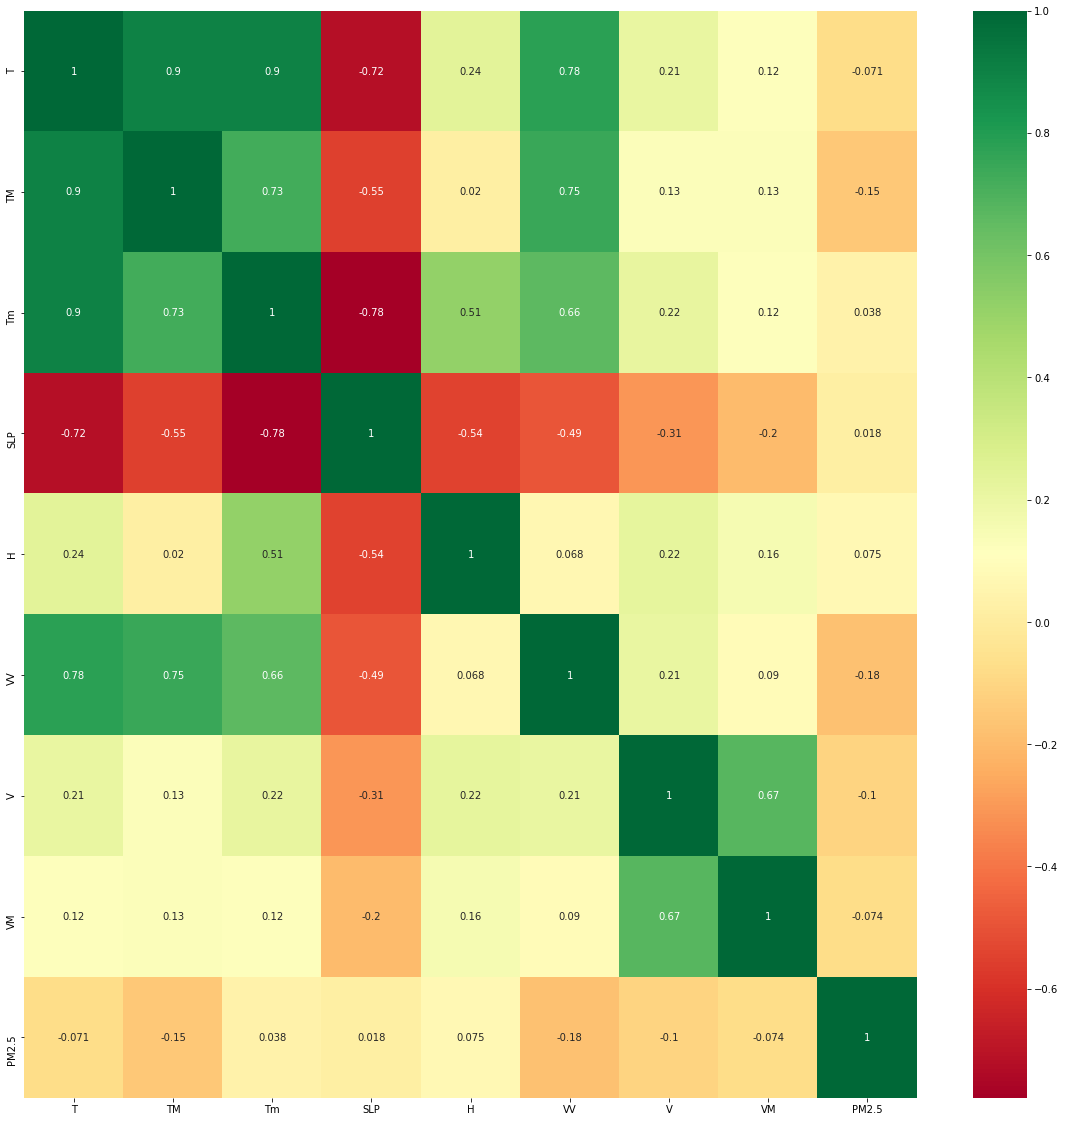

In [17]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [18]:
corrmat.index

Index(['T', 'TM', 'Tm', 'SLP', 'H', 'VV', 'V', 'VM', 'PM2.5'], dtype='object')

In [19]:
## checking feature importance 
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
model = ExtraTreesRegressor()
model.fit(X,y)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [20]:
X.head()

,T,TM,Tm,SLP,H,VV,V,VM
0,29.3,34.1,26.5,1004.7,83.0,4.5,1.9,3.5
1,29.0,34.0,25.8,1007.0,79.0,4.5,0.6,3.5
2,28.9,32.3,27.2,1008.5,84.0,5.0,0.7,3.5
3,28.1,33.0,26.4,1004.8,84.0,4.5,0.7,3.5
4,28.8,33.5,26.6,1004.3,79.0,4.7,0.6,3.5


In [21]:
print(model.feature_importances_)

[0.11010073 0.12391212 0.16150371 0.13372096 0.11531772 0.13756742
 0.11773957 0.10013776]


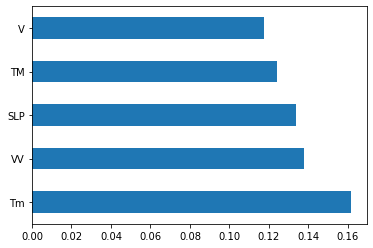

In [22]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


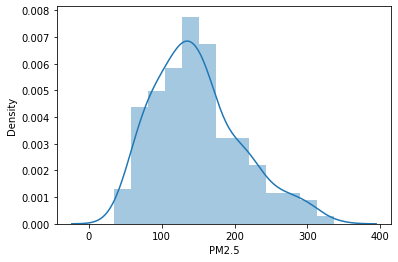

In [23]:
sns.distplot(y)

In [24]:
## using linear regression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [25]:
from sklearn.linear_model import LinearRegression
regressor=LinearRegression()
regressor.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
regressor.coef_

array([ -0.48830068,  -6.22058868,   9.31507966,   0.79706186,
        -0.90793903, -22.25757831,  -2.04375247,  -0.26461291])

In [27]:
regressor.intercept_

-488.07692200496234

In [28]:
print("Coefficient of determination R^2 <-- on train set: {}".format(regressor.score(X_train, y_train)))

Coefficient of determination R^2 <-- on train set: 0.11404029638160994


In [29]:
print("Coefficient of determination R^2 <-- on train set: {}".format(regressor.score(X_test, y_test)))

Coefficient of determination R^2 <-- on train set: 0.1271517569489442


In [30]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(regressor,X,y,cv=5)

In [31]:
score.mean()

-0.7919452063812067

In [32]:
coeff_df = pd.DataFrame(regressor.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
T,-0.488301
TM,-6.220589
Tm,9.315080
SLP,0.797062
H,-0.907939
VV,-22.257578
V,-2.043752
VM,-0.264613


In [33]:
prediction=regressor.predict(X_test)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


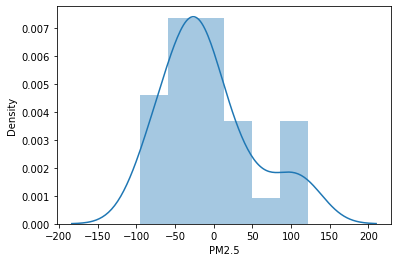

In [34]:
sns.distplot(y_test-prediction)

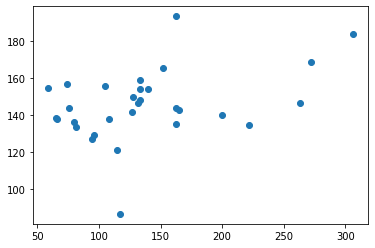

In [35]:
plt.scatter(y_test,prediction)

In [36]:
from sklearn import metrics

In [37]:
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))
print("R2 score =", round(metrics.r2_score(y_test, prediction), 2))

MAE: 47.03052327032813
MSE: 3307.2561627150376
RMSE: 57.50874857545622
R2 score = 0.13
